In [16]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
ds = load_breast_cancer()
ds_df = pd.DataFrame(ds.data, columns=ds.feature_names)
ds_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [18]:

X_train, X_test, y_train, y_test = train_test_split(ds.data, ds.target, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(455, 30)
(455,)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DNNClassifier(nn.Module):
    def __init__(self, input_dim: int, hidden_dims=(64, 32), dropout: float = 0.2):
        super().__init__()
        layers = []
        in_features = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_features, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=dropout))
            in_features = hidden_dim
        # Output layer for binary classification (logit output)
        layers.append(nn.Linear(in_features, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Returns logits; apply sigmoid only for metrics, not for loss
        logits = self.network(x)
        return logits.view(-1)

In [20]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# scale features using train fit only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
valid_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=256, shuffle=False)

input_dim = X_train.shape[1]
model = DNNClassifier(input_dim=input_dim, hidden_dims=(128, 64, 32), dropout=0.3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_logits = []
    all_targets = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        running_loss += loss.item() * xb.size(0)
        all_logits.append(logits.cpu())
        all_targets.append(yb.cpu())
    logits_cat = torch.cat(all_logits)
    targets_cat = torch.cat(all_targets)
    probs = torch.sigmoid(logits_cat)
    preds = (probs >= 0.5).float()
    acc = accuracy_score(targets_cat.numpy(), preds.numpy())
    try:
        auc = roc_auc_score(targets_cat.numpy(), probs.numpy())
    except ValueError:
        auc = float('nan')
    return running_loss / len(loader.dataset), acc, auc

EPOCHS = 30
best_val_auc = -1.0
for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_auc = evaluate(model, valid_loader, criterion, device)
    scheduler.step()
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | val_auc={val_auc:.4f}")
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# load best
model.load_state_dict(best_state)
val_loss, val_acc, val_auc = evaluate(model, valid_loader, criterion, device)
print(f"Best | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | val_auc={val_auc:.4f}")


Epoch 01 | train_loss=0.5912 | val_loss=0.5808 | val_acc=0.9561 | val_auc=0.9951
Epoch 02 | train_loss=0.4277 | val_loss=0.4276 | val_acc=0.9649 | val_auc=0.9974
Epoch 03 | train_loss=0.3633 | val_loss=0.3241 | val_acc=0.9649 | val_auc=0.9977
Epoch 04 | train_loss=0.3088 | val_loss=0.2843 | val_acc=0.9649 | val_auc=0.9974
Epoch 05 | train_loss=0.2814 | val_loss=0.2595 | val_acc=0.9561 | val_auc=0.9954
Epoch 06 | train_loss=0.2579 | val_loss=0.2461 | val_acc=0.9474 | val_auc=0.9961
Epoch 07 | train_loss=0.2431 | val_loss=0.2299 | val_acc=0.9561 | val_auc=0.9961
Epoch 08 | train_loss=0.2267 | val_loss=0.2078 | val_acc=0.9649 | val_auc=0.9954
Epoch 09 | train_loss=0.2086 | val_loss=0.1898 | val_acc=0.9649 | val_auc=0.9961
Epoch 10 | train_loss=0.1963 | val_loss=0.1786 | val_acc=0.9561 | val_auc=0.9964
Epoch 11 | train_loss=0.1878 | val_loss=0.1675 | val_acc=0.9561 | val_auc=0.9954
Epoch 12 | train_loss=0.1917 | val_loss=0.1680 | val_acc=0.9649 | val_auc=0.9961
Epoch 13 | train_loss=0.1672

In [22]:
y_pred = model(X_test_t)
y_pred = (y_pred > 0.5).float()
print(y_pred)
print(y_test_t)

tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 1., 0., 0.])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       

Precision: 1.0
recall: 0.8732394366197183
f1: 0.9323308270676691
accuracy: 0.9210526315789473
<class 'numpy.ndarray'>
0.11207125030354681
0.12050105655770527


/opt/anaconda3/envs/xai/lib/python3.13/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""
/opt/anaconda3/envs/xai/lib/python3.13/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


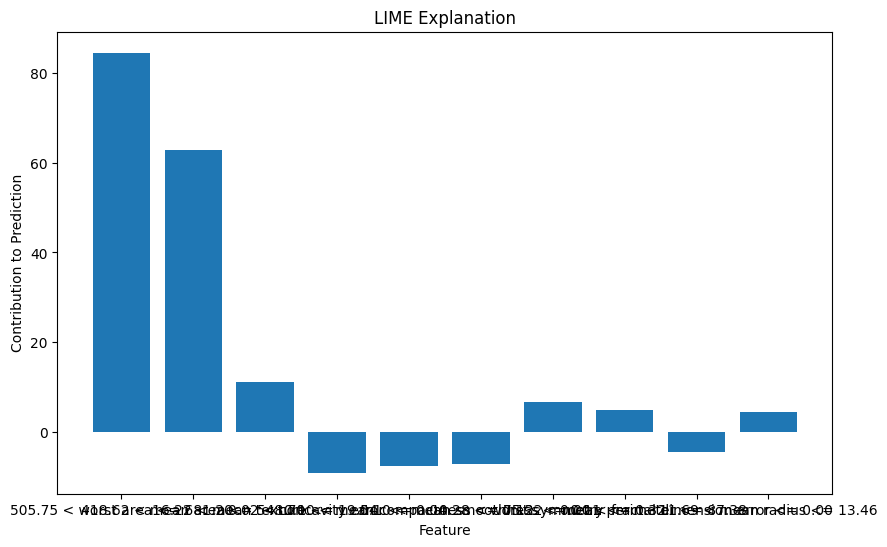

In [23]:
# Measure precision, recall, and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import lime
import lime.lime_tabular

precision = precision_score(y_test_t.numpy(), y_pred.numpy())
recall = recall_score(y_test_t.numpy(), y_pred.numpy())
f1 = f1_score(y_test_t.numpy(), y_pred.numpy())
accuracy = accuracy_score(y_test_t.numpy(), y_pred.numpy())
print(f"Precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")
print(f"accuracy: {accuracy}")

# # Plot precision vs recall curve
# from sklearn.metrics import precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(y_test_t.numpy(), y_pred.numpy())
# plt.plot(recall, precision)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision vs Recall Curve')
# plt.show()

# Explain the model using LIME
print(type(X_test))

# Create a wrapper function for LIME that converts numpy arrays to tensors
def model_predict_fn(x):
    # Convert numpy array to tensor
    x_tensor = torch.tensor(x, dtype=torch.float32)
    # Get predictions
    with torch.no_grad():
        predictions = model(x_tensor)
    # Convert to probabilities for LIME (it expects probability scores)
    # For binary classification, LIME expects shape (n_samples, 2) with [prob_class_0, prob_class_1]
    prob_class_1 = predictions.numpy()
    prob_class_0 = 1 - prob_class_1
    # Stack to create shape (n_samples, 2)
    probabilities = np.column_stack([prob_class_0, prob_class_1])
    return probabilities

explainer = lime.lime_tabular.LimeTabularExplainer(X_test, feature_names=ds.feature_names, class_names=ds.target_names, discretize_continuous=True, mode='classification')
explanation = explainer.explain_instance(X_test[0], model_predict_fn, num_features=10)
print(explanation.score)

bc1_lime = explainer.explain_instance(X_test[0], model_predict_fn, num_features=10, top_labels=1)
print(bc1_lime.score)

# Plot the explanation
plt.figure(figsize=(10, 6))
plt.bar(range(len(explanation.as_list())), [item[1] for item in explanation.as_list()], align='center')
plt.xticks(range(len(explanation.as_list())), [item[0] for item in explanation.as_list()])
plt.xlabel('Feature')
plt.ylabel('Contribution to Prediction')
plt.title('LIME Explanation')
plt.show()